In [1]:
import utils
import cv2
import imutils
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

In [64]:
class ImageMerger:
    """
    ImageMerger can merge images from a dataset including images collected by a drone with the purpose of detecting 
    moving people in the images.
    """
    def __init__(self, data_dir, mask_file):
        """
        :param data_dir: path to the directory where the data is located
        :param mask_file: path of a mask which removes unneccesary text from the images
        """
        
        # Get all directories inside the data_dir
        self.data_dir = data_dir
        self.dirs = os.listdir(data_dir)
        self.mask = np.array(cv2.imread(mask_file)) // 255
        
        # Store the merged images
        self.merged_images = {}
        
    def load_images(self):
        """
        Loads the images and homographies from one directory at a time and yields them
        """
        
        for a_dir in self.dirs:
            input_images = {}
            
            # Load all images in the train directory
            image_dir_file_path = os.path.join(os.path.join(self.data_dir, a_dir), '*.png')
            images = glob.glob(image_dir_file_path)
            
            # Copy all the raw images to the input images dict
            for im in images:
                file = os.path.basename(im)
                img_name = os.path.splitext(file)[0]
                src = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
                src = self.apply_mask(src)
                input_images[img_name] = src
            
            # Load the homographies json file
            homographies_file_path = os.path.join(os.path.join(self.data_dir, a_dir), 'homographies.json')
            with open(homographies_file_path, 'rb') as f:
                homographies = json.load(f)
            
            yield a_dir, input_images, homographies
        
    def apply_mask(self, image):
        """
        Applys the provided mask on image
        :param image: image file which will be treated as np.array
        """

        return image * self.mask
    
    def merge_images(self, alpha=0.75, axis=0, method='cltr', debug=False):
        """
        Merges all the images given the homographies which are retrieved from load_data. 
        :param alpha: Weighting for merging the images. The image to be merged on will be considered with a weight a alpha,
        the second image with a weight of 1-alpha.
        :param axis: defines the axis along which the images shall be merged. 0: camera axis, 1: time axis
        :param method: defines in which order the images shall be merged:
            - cltr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on it
                    from left to right along the camera axis or from the first in time (index 0) to the last in time (index
                    6)
            - crtl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on it
                    from right to left along the camera axis or from the last in time (index 6) to the first in time (index
                    0)
            - coutl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the center out switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the left side/previous in time. 
            - coutr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the center out switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the right side/next in time.
            - cinl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the outside inward switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the left side/previous in time. 
            - cinr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the outside inward switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the right side/next in time.
        :param debug: if True, results are printed to be able to debug 
        """
        
        # Define the keys and indices depending on axis and method
        keys = []
        indices = []
        base = None
        if axis == 0:
            indices = range(0, 7)
            if method == 'cltr':
                base = '-B01'
                keys = ['-B05', '-B04', '-B03', '-B02', '-G01', '-G02', '-G03', '-G04', '-G05']
            elif method == 'crtl': 
                base = '-B01'
                keys = ['-G05', '-G04', '-G03', '-G02', '-G01', '-B02', '-B03', '-B04', '-B05']
            elif method == 'coutl':
                base = '-B01'
                keys = ['-B02', '-G01', '-B03', '-G02', '-B04', '-G03', '-B05', '-G04', '-G05']
            elif method == 'coutr':
                base = '-B01'
                keys = ['-G01', '-B02', '-G02', '-B03', '-G03', '-B04', '-G04', '-B05', '-G05']
            elif method == 'cinl':
                base = '-B01'
                keys = ['-B05', '-G05', '-B04', '-G04', '-B03', '-G03', '-B02', '-G02', '-G01']
            elif method == 'cinr':
                base = '-B01'
                keys = ['-G05', '-B05', '-G04', '-B04', '-G03', '-B03', '-G02', '-B02', '-G01']
        elif axis == 1:
            indices = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            if method == 'cltr':
                base = 3
                keys = [0, 1, 2, 4, 5, 6]
            elif method == 'crtl': 
                base = 3
                keys = [6, 5, 4, 2, 1, 0]
            elif method == 'coutl':
                base = 3
                keys = [2, 4, 1, 5, 0, 6]
            elif method == 'coutr':
                base = 3
                keys = [4, 2, 5, 1, 6, 0]
            elif method == 'cinl':
                base = 3
                keys = [0, 6, 1, 5, 2, 4]
            elif method == 'cinr':
                base = 3
                keys = [6, 0, 5, 1, 4, 2]
                
        # Do the merging by looping through all indices and keys
        for a_dir, images, homographies in self.load_images():
            # Loop through the indices
            for i in indices: 
                # Load the base image depending on the method
                base_image_key = ''
                if axis == 0:
                    base_image_key = str(i) + base
                elif axis == 1:
                    base_image_key = str(base) + i
                    
                # Define the merged image and set it to the base image as the start
                merged_image = images[base_image_key]
                
                if debug:
                    print('directory: ', a_dir)
                    print('base key: ', base_image_key)

                for k in keys:
                    # Get the key given the index and k
                    key = ''
                    if axis == 0:
                        key = str(i) + k
                    elif axis == 1:
                         key = str(k) + i
                        
                    # Load the image and the corresponding homography matrix
                    im = images[key]
                    homography = np.array(homographies[key])
                    
                    # Warp the perspective (i.e. transform the current image into the perspective of the base image (-B01))
                    im_warped = cv2.warpPerspective(im, homography, im.shape[:2])
                    # Merge the images
                    merged_image = cv2.addWeighted(merged_image, alpha, im_warped, 1 - alpha, 0.0)

                self.merged_images[a_dir] = merged_image
                
                if debug:
                    plt.imshow(merged_image)
                    plt.show()
            break

directory:  train-1-0
base key:  0-B01


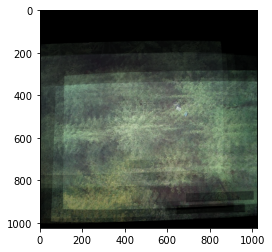

directory:  train-1-0
base key:  1-B01


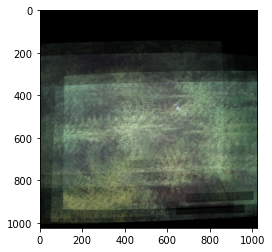

directory:  train-1-0
base key:  2-B01


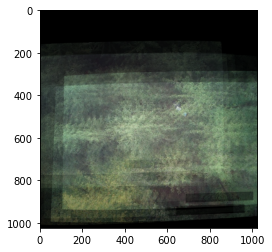

directory:  train-1-0
base key:  3-B01


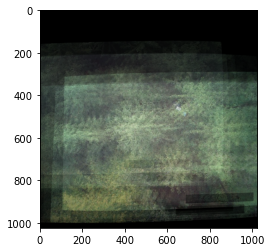

directory:  train-1-0
base key:  4-B01


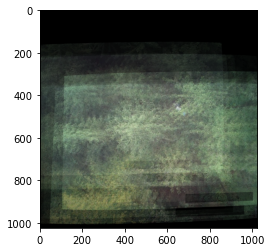

directory:  train-1-0
base key:  5-B01


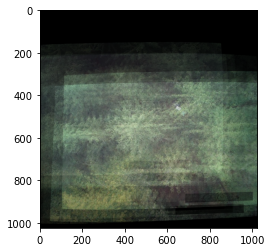

directory:  train-1-0
base key:  6-B01


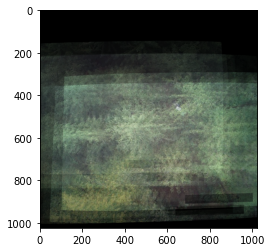

directory:  train-1-1
base key:  0-B01


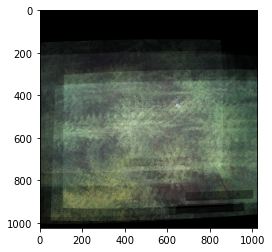

directory:  train-1-1
base key:  1-B01


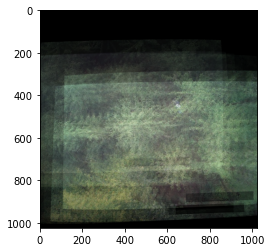

directory:  train-1-1
base key:  2-B01


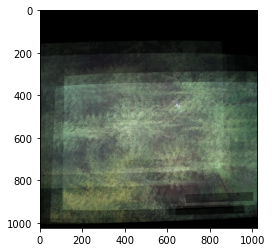

directory:  train-1-1
base key:  3-B01


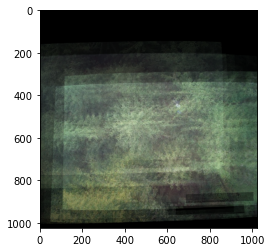

directory:  train-1-1
base key:  4-B01


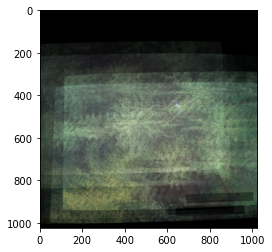

directory:  train-1-1
base key:  5-B01


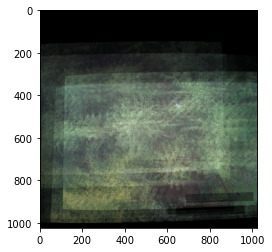

directory:  train-1-1
base key:  6-B01


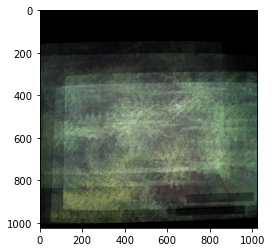

directory:  train-1-10
base key:  0-B01


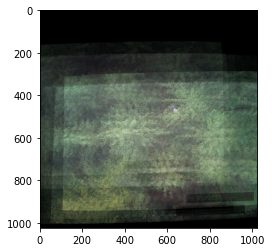

directory:  train-1-10
base key:  1-B01


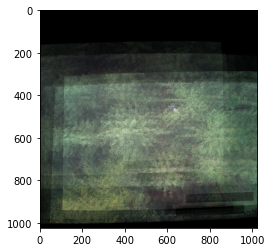

directory:  train-1-10
base key:  2-B01


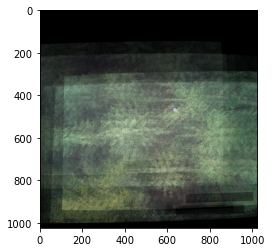

directory:  train-1-10
base key:  3-B01


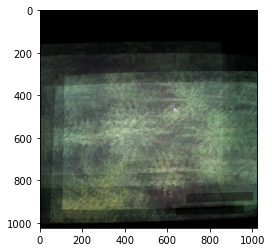

directory:  train-1-10
base key:  4-B01


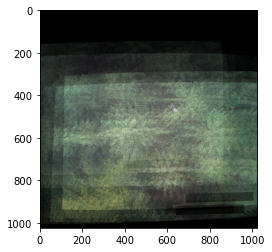

directory:  train-1-10
base key:  5-B01


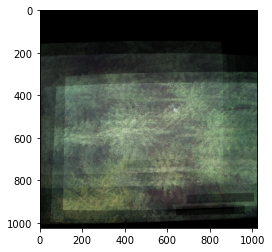

directory:  train-1-10
base key:  6-B01


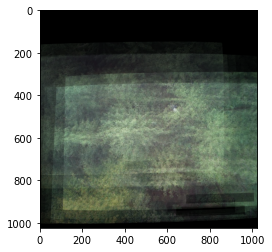

directory:  train-1-11
base key:  0-B01


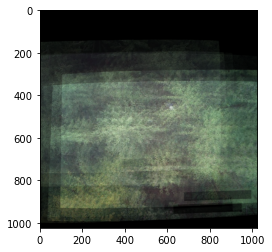

directory:  train-1-11
base key:  1-B01


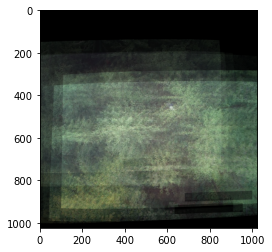

directory:  train-1-11
base key:  2-B01


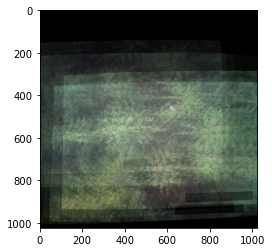

directory:  train-1-11
base key:  3-B01


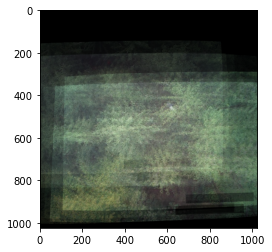

directory:  train-1-11
base key:  4-B01


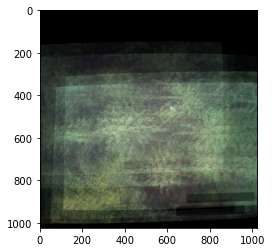

directory:  train-1-11
base key:  5-B01


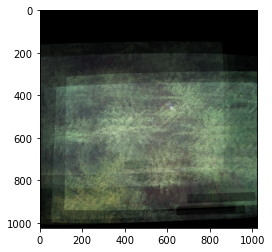

directory:  train-1-11
base key:  6-B01


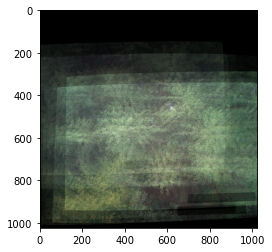

directory:  train-1-12
base key:  0-B01


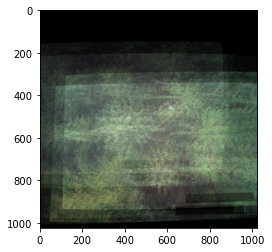

directory:  train-1-12
base key:  1-B01


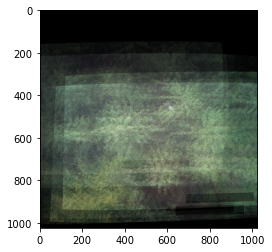

directory:  train-1-12
base key:  2-B01


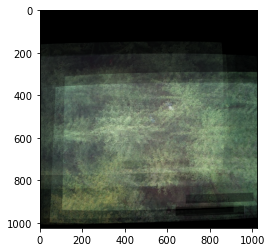

directory:  train-1-12
base key:  3-B01


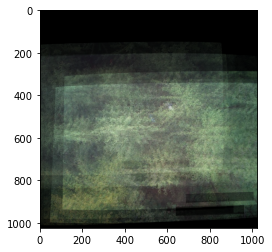

directory:  train-1-12
base key:  4-B01


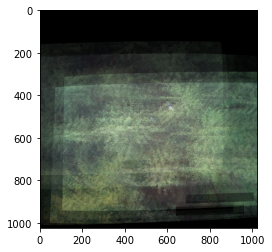

directory:  train-1-12
base key:  5-B01


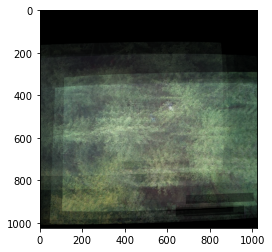

directory:  train-1-12
base key:  6-B01


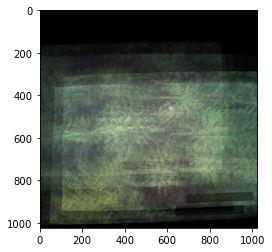

directory:  train-1-13
base key:  0-B01


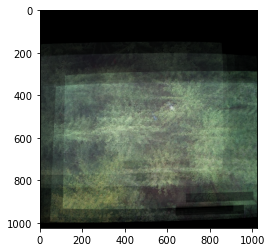

directory:  train-1-13
base key:  1-B01


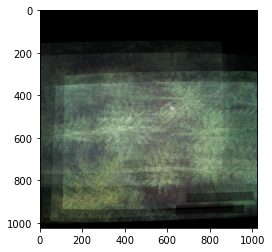

directory:  train-1-13
base key:  2-B01


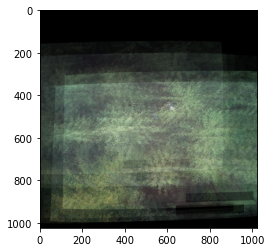

directory:  train-1-13
base key:  3-B01


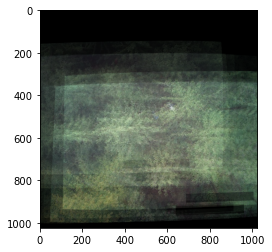

directory:  train-1-13
base key:  4-B01


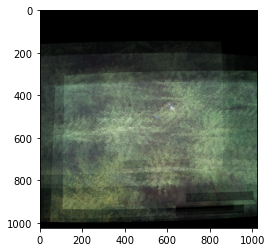

directory:  train-1-13
base key:  5-B01


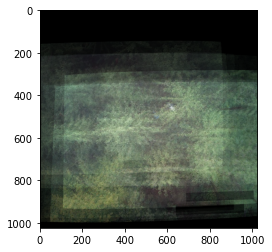

directory:  train-1-13
base key:  6-B01


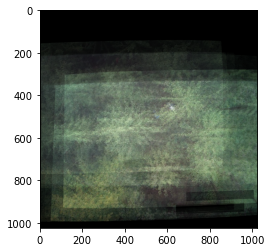

directory:  train-1-14
base key:  0-B01


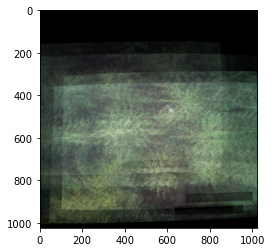

directory:  train-1-14
base key:  1-B01


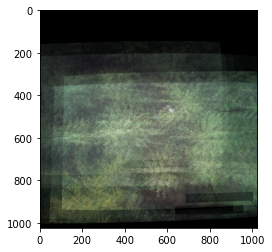

directory:  train-1-14
base key:  2-B01


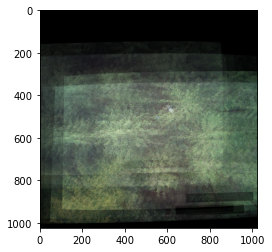

directory:  train-1-14
base key:  3-B01


KeyboardInterrupt: 

In [63]:
image_merger = ImageMerger('data_WiSAR/data/train/', 'data_WiSAR/data/mask.png')
image_merger.merge_images(axis=0, method='coutl', debug=True)